<a href="https://colab.research.google.com/github/nipunikajain/ExperimentsWithLLM/blob/main/PEFT_LoRa_GBD_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pdfplumber

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [1]:
import pdfplumber

def pdf_to_text(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text()
    return text

pdf_path = "global-business-driven-hr-transformation.pdf"
text = pdf_to_text(pdf_path)

# You can save the extracted text to a file if you want
with open("output_text.txt", "w", encoding="utf-8") as file:
    file.write(text)


ModuleNotFoundError: ignored

In [1]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-0d82f89f-a88a-0351-dcee-d7d59baafdd6)


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
import os
import transformers
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "bigscience/bloom-7b1", 
    load_in_8bit=True, 
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-7b1")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Freezing the Original Weights

In [5]:
for param in model.parameters():
  param.requires_grad= False # freeze the model - train adapters later
  if param.ndim ==1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)
  
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self,x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

### Setting up the LoRa Adapters

In [6]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

### Combining model with LoRa adapters

In [7]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16, #attention heads
    lora_alpha=32, #alpha scaling
    #target_modules =["q_proj", "v_proj"]
    lora_dropout = 0.05,
    bias = "none",
    task_type="CAUSAL_LM" # set this for CLM or Seq2Seq
)

model= get_peft_model(model,config)
print_trainable_parameters(model)

trainable params: 7864320 || all params: 7076880384 || trainable%: 0.11112693126452029


### Data Tokenization

In [8]:
def read_text_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return file.read()

text_file_path = "output_text.txt"  # Replace with the path to your text file
text = read_text_file(text_file_path)

train_split = 0.8  # Use 80% of the data for training, adjust the ratio as needed

text_lines = text.splitlines()
num_train_lines = int(len(text_lines) * train_split)
train_text = "\n".join(text_lines[:num_train_lines])
validation_text = "\n".join(text_lines[num_train_lines:])

In [9]:
train_tokenized_text = tokenizer(train_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

validation_tokenized_text = tokenizer(validation_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

### Converting to PyTorch Dataset

In [10]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, tokenized_data):
        self.tokenized_data = tokenized_data

    def __len__(self):
        return len(self.tokenized_data["input_ids"])

    def __getitem__(self, idx):
        return {key: value[idx] for key, value in self.tokenized_data.items()}

train_dataset = CustomDataset(train_tokenized_text)
validation_dataset = CustomDataset(validation_tokenized_text)


In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [12]:
class CustomTrainer(transformers.Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.training_losses = []
        self.validation_losses = []

    def log(self, logs):
        super().log(logs)
        if "loss" in logs:
            self.training_losses.append(logs["loss"])
        if "eval_loss" in logs:
            self.validation_losses.append(logs["eval_loss"])
            clear_output(wait=True)
            plt.plot(self.training_losses, label="Training Loss")
            plt.plot(self.validation_losses, label="Validation Loss")
            plt.xlabel("Step")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()


In [27]:
import torch.optim as optim


In [35]:
# from transformers import TrainingArguments, Trainer, get_scheduler

# # Define your model and datasets

# training_args = TrainingArguments(
#     output_dir='./results',          # output directory
#     num_train_epochs=10,             # total number of training epochs
#     learning_rate=5e-5,              # initial learning rate
#     per_device_train_batch_size=8,   # batch size per device during training
#     per_device_eval_batch_size=8,    # batch size for evaluation
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='./logs',            # directory for storing logs
#     logging_steps=10,
#     eval_steps=10,
#     save_total_limit=3,
#     fp16=True,                       # mixed precision training
#     dataloader_num_workers=4,
# )

# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=validation_dataset,
#     data_collator=transformers.DataCollatorForLanguageModeling(
#          tokenizer, mlm=False),
#     warmup_steps=30,
#     max_steps=50,
# )


# trainer.train()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 21>:21                                                                            │
│ in __init__:3                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: Trainer.__init__() got an unexpected keyword argument 'warmup_steps'

In [22]:
# from transformers import EarlyStoppingCallback, HfArgumentParser, LearningRateCallback

# # Define the hyperparameter grid
# hyperparameter_grid = {
#     "learning_rate": [5e-5, 1e-4, 5e-4],
#     "weight_decay": [0.01, 0.001, 0.0001],
#     "dropout_rate": [0.1, 0.2, 0.3],
# }

# # Define a learning rate schedule
# def learning_rate_schedule(current_lr, step):
#     if step < 10:
#         return current_lr / 10
#     else:
#         return current_lr

# # Parse the hyperparameters
# parser = HyperParameterArgumentParser()
# parser.add_hyperparameters(hyperparameter_grid)
# args = parser.parse_args()

# # Set up the trainer with the hyperparameters
# trainer = CustomTrainer(
#     model=model,
#     train_dataset=train_dataset,
#     eval_dataset=validation_dataset,
#     args=transformers.TrainingArguments(
#         per_device_train_batch_size=4,
#         gradient_accumulation_steps=4,
#         warmup_steps=30,
#         max_steps=50,
#         learning_rate=args.learning_rate,
#         fp16=True,
#         logging_steps=1,
#         evaluation_strategy="steps",
#         output_dir="outputs",
#         weight_decay=args.weight_decay,
#     ),
#     data_collator=transformers.DataCollatorForLanguageModeling(
#         tokenizer, mlm=False
#     ),
# )

# # Add dropout to the model (if not already present)
# if not hasattr(model.config, "dropout"):
#     model.config.dropout = 0.1

# # Set up the callbacks
# callbacks = [LearningRateCallback, EarlyStoppingCallback(early_stopping_patience=5)]

# # Train the model
# trainer.hyperparameter_search(callbacks=callbacks, direction="minimize")



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553 in run_code        │
│                                                                                                  │
│   3550 │   │   │   │   elif async_ :                                                             │
│   3551 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3552 │   │   │   │   else:                                                                     │
│ ❱ 3553 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3554 │   │   │   finally:                                                                      │
│   3555 │   │   │   │   # Reset our crash handler in place                                        │
│   3556 │   │   │   │   sys.excepthook = old_excepthook                                           │
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: cannot import name 'LearningRateCallback' from 'transformers' 
(/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

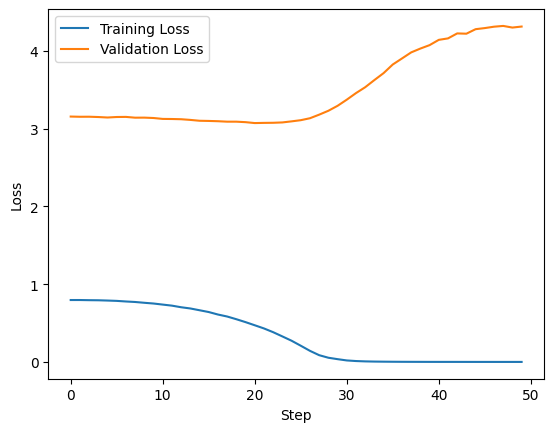

Step,Training Loss,Validation Loss
1,0.796300,3.154472
2,0.796300,3.151808
3,0.794300,3.152360
4,0.793100,3.148468
5,0.789500,3.142318
6,0.785300,3.148761
7,0.777600,3.150085
8,0.771100,3.140072
9,0.760800,3.140781
10,0.751400,3.135886


TrainOutput(global_step=50, training_loss=0.3343247076065745, metrics={'train_runtime': 47.7839, 'train_samples_per_second': 16.742, 'train_steps_per_second': 1.046, 'total_flos': 232292194713600.0, 'train_loss': 0.3343247076065745, 'epoch': 50.0})

In [13]:
trainer = CustomTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=30,
        max_steps=50,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        output_dir="outputs",
        weight_decay=0.01,  # L2 regularization
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False
    ),
)
# # Add dropout to the model (if not already present)
# model.config.dropout = 0.1

model.config.use_cache = False  # silence the warning, Please re-enable for inference!
trainer.train()


### Training

In [12]:
# trainer = transformers.Trainer(
#     model=model,
#     train_dataset = train_dataset,
#     eval_dataset=validation_dataset,
#     args = transformers.TrainingArguments(
#         per_device_train_batch_size=4,
#         gradient_accumulation_steps=4,
#         warmup_steps=10,
#         max_steps=30,
#         learning_rate=2e-4,
#         fp16=True,
#         logging_steps=1,
#         output_dir='outputs'
#     ),
#     data_collator = transformers.DataCollatorForLanguageModeling(tokenizer,mlm=False)
# )
# model.config.use_cache = False # silence the warning, Please re-enable for inference!
# trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
1,0.796300
2,0.796300
3,0.793700
4,0.787700
5,0.775100
6,0.759400
7,0.737300
8,0.712800
9,0.679900
10,0.644700


TrainOutput(global_step=30, training_loss=0.3905436106026173, metrics={'train_runtime': 20.3346, 'train_samples_per_second': 23.605, 'train_steps_per_second': 1.475, 'total_flos': 139375316828160.0, 'train_loss': 0.3905436106026173, 'epoch': 30.0})

In [13]:
# evaluation_results = trainer.evaluate()
# print(evaluation_results)


{'eval_loss': 3.2204298973083496, 'eval_runtime': 0.1752, 'eval_samples_per_second': 5.707, 'eval_steps_per_second': 5.707, 'epoch': 30.0}


### Saving the model to Hub

In [14]:
model.push_to_hub("nipunikajain/bloom-7b1-lora-GBD_transformer",
                  use_auth_token=True,
                  commit_message="basic training",
                  private=True)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nipunikajain/bloom-7b1-lora-GBD_transformer/commit/e073d3a0d6687c716da1eae5f17f2b74a22a75bc', commit_message='basic training', commit_description='', oid='e073d3a0d6687c716da1eae5f17f2b74a22a75bc', pr_url=None, pr_revision=None, pr_num=None)

### Loading the model from Hub

In [15]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "nipunikajain/bloom-7b1-lora-GBD_transformer"
config = PeftConfig.from_pretrained(peft_model_id)

model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True,
                                             load_in_8bit=True, device_map='auto')

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Prompt Testing

In [18]:
batch = tokenizer("tell me about Future of Talent Management", return_tensors='pt')

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=50)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))



 tell me about Future of Talent Management
See our new TV series
See our new TV series
See our new TV series
See our new TV series
See our new TV series
See our new TV series
See our new TV series
See our new TV series
See
